### Investigating data through SQL queries and plots

In [1]:
import sqlite3
from sklearn import metrics
from scipy.sparse import hstack
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm 
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

In [2]:
cnx = sqlite3.connect('DebateOrg/ddo-V1.db')
c = cnx.cursor()

In [3]:
#Total number of debates won by men
c.execute('SELECT count(users.number_of_won_debates) FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.gender="Male"')
results = c.fetchall()
results

[(25954,)]

In [4]:
#Total number of debates won by women
c.execute('SELECT count(users.number_of_won_debates) FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.gender="Female"')
results = c.fetchall()
results

[(7642,)]

In [5]:
#The total number of Conservatives and Liberals
c.execute('SELECT count(users.ideology) FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Conservative"')
results_con = c.fetchall()
c.execute('SELECT count(users.ideology) FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Liberal"')
results_lib = c.fetchall()


print(f"The toal number of conservatives is {results_con[0][0]} and the total number of liberals is {results_lib[0][0]}")

The toal number of conservatives is 6814 and the total number of liberals is 4340


In [6]:
#Conservatives users' favorite categories 
c.execute('SELECT count(users.url) as counts, users.gender, debates.category FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Conservative" GROUP BY category,users.gender')
c.fetchall()

[(11, 'Female', 'Arts'),
 (51, 'Male', 'Arts'),
 (12, 'Prefer not to say', 'Arts'),
 (1, 'Female', 'Cars'),
 (9, 'Male', 'Cars'),
 (6, 'Prefer not to say', 'Cars'),
 (7, 'Female', 'Economics'),
 (97, 'Male', 'Economics'),
 (47, 'Prefer not to say', 'Economics'),
 (46, 'Female', 'Education'),
 (109, 'Male', 'Education'),
 (88, 'Prefer not to say', 'Education'),
 (49, 'Female', 'Entertainment'),
 (174, 'Male', 'Entertainment'),
 (73, 'Prefer not to say', 'Entertainment'),
 (5, 'Female', 'Fashion'),
 (2, 'Male', 'Fashion'),
 (7, 'Prefer not to say', 'Fashion'),
 (4, 'Female', 'Funny'),
 (45, 'Male', 'Funny'),
 (70, 'Prefer not to say', 'Funny'),
 (4, 'Female', 'Games'),
 (33, 'Male', 'Games'),
 (56, 'Prefer not to say', 'Games'),
 (30, 'Female', 'Health'),
 (96, 'Male', 'Health'),
 (56, 'Prefer not to say', 'Health'),
 (47, 'Female', 'Miscellaneous'),
 (408, 'Male', 'Miscellaneous'),
 (113, 'Prefer not to say', 'Miscellaneous'),
 (3, 'Female', 'Movies'),
 (7, 'Male', 'Movies'),
 (8, 'Pref

In [7]:
#Liberal users' favorite categories 
c.execute('SELECT count(users.url) as counts, users.gender, debates.category FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Liberal" GROUP BY category,users.gender')
c.fetchall()

[(8, 'Female', 'Arts'),
 (29, 'Male', 'Arts'),
 (11, 'Prefer not to say', 'Arts'),
 (1, 'Female', 'Cars'),
 (2, 'Male', 'Cars'),
 (3, 'Prefer not to say', 'Cars'),
 (1, 'Androgyne', 'Economics'),
 (7, 'Female', 'Economics'),
 (38, 'Male', 'Economics'),
 (16, 'Prefer not to say', 'Economics'),
 (1, 'Agender', 'Education'),
 (3, 'Bigender', 'Education'),
 (36, 'Female', 'Education'),
 (85, 'Male', 'Education'),
 (47, 'Prefer not to say', 'Education'),
 (1, 'Androgyne', 'Entertainment'),
 (28, 'Female', 'Entertainment'),
 (165, 'Male', 'Entertainment'),
 (51, 'Prefer not to say', 'Entertainment'),
 (2, 'Female', 'Fashion'),
 (1, 'Male', 'Fashion'),
 (3, 'Prefer not to say', 'Fashion'),
 (8, 'Female', 'Funny'),
 (31, 'Male', 'Funny'),
 (13, 'Prefer not to say', 'Funny'),
 (2, 'Female', 'Games'),
 (38, 'Male', 'Games'),
 (19, 'Prefer not to say', 'Games'),
 (2, 'Androgyne', 'Health'),
 (43, 'Female', 'Health'),
 (95, 'Male', 'Health'),
 (36, 'Prefer not to say', 'Health'),
 (2, 'Agender', '

#### Category distribution

In [8]:
#We have three different gender for the group of Conservatives: Male, Female, Prefer not to say
#Some liberals identify themselves in different genders such as Non binary, Androgyn etc 
#For the sake of semplicity I decided to keep just three types of gender
#We can plot those prefences in a stacked bar chart

#let's create a dataset

women_men_con=pd.read_sql_query('SELECT count(users.url) as counts, users.gender, debates.category FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Conservative" GROUP BY category,users.gender',cnx)
women_men_lib=pd.read_sql_query('SELECT count(users.url) as counts, users.gender, debates.category FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Liberal" GROUP BY category,users.gender',cnx)


women_men_con.head()

,counts,gender,category
0,11,Female,Arts
1,51,Male,Arts
2,12,Prefer not to say,Arts
3,1,Female,Cars
4,9,Male,Cars


In [9]:
merging=pd.merge(women_men_con, women_men_lib, on=["category","gender"])
merging=merging.rename(columns={"counts_x":"conservative", "counts_y":"liberal"})

In [10]:
merging["category"].values
#places-travel has a gender missing(the female one)

array(['Arts', 'Arts', 'Arts', 'Cars', 'Cars', 'Cars', 'Economics',
       'Economics', 'Economics', 'Education', 'Education', 'Education',
       'Entertainment', 'Entertainment', 'Entertainment', 'Fashion',
       'Fashion', 'Fashion', 'Funny', 'Funny', 'Funny', 'Games', 'Games',
       'Games', 'Health', 'Health', 'Health', 'Miscellaneous',
       'Miscellaneous', 'Miscellaneous', 'Movies', 'Movies', 'Movies',
       'Music', 'Music', 'Music', 'News', 'News', 'News', 'People',
       'People', 'People', 'Philosophy', 'Philosophy', 'Philosophy',
       'Places-Travel', 'Places-Travel', 'Politics', 'Politics',
       'Politics', 'Religion', 'Religion', 'Religion', 'Science',
       'Science', 'Science', 'Society', 'Society', 'Society', 'Sports',
       'Sports', 'Sports', 'TV', 'TV', 'TV', 'Technology', 'Technology',
       'Technology'], dtype=object)

In [11]:
merging[(merging["gender"]=="Female") & (merging["category"]=='Places-Travel')]

,conservative,gender,category,liberal


In [12]:
merging[merging["category"]=='Places-Travel']

,conservative,gender,category,liberal
45,5,Male,Places-Travel,2
46,11,Prefer not to say,Places-Travel,3


In [13]:
#I decided to add a row with 0 as counts
merging.loc[-1] = [0, "Female", "Places-Travel",0]  # adding a row
merging.index = merging.index + 1  # shifting index
merging = merging.sort_index()  # sorting by index

merging_1=pd.DataFrame()
merging_1=merging_1.append(merging[merging["category"]!='Places-Travel'])
merging_1=merging_1.append(merging[merging["category"]=='Places-Travel'])
merging_1

,conservative,gender,category,liberal
1,11,Female,Arts,8
2,51,Male,Arts,29
3,12,Prefer not to say,Arts,11
4,1,Female,Cars,1
5,9,Male,Cars,2
...,...,...,...,...
67,54,Male,Technology,48
68,17,Prefer not to say,Technology,14
0,0,Female,Places-Travel,0
46,5,Male,Places-Travel,2


In [14]:
merging_1["category"].values

array(['Arts', 'Arts', 'Arts', 'Cars', 'Cars', 'Cars', 'Economics',
       'Economics', 'Economics', 'Education', 'Education', 'Education',
       'Entertainment', 'Entertainment', 'Entertainment', 'Fashion',
       'Fashion', 'Fashion', 'Funny', 'Funny', 'Funny', 'Games', 'Games',
       'Games', 'Health', 'Health', 'Health', 'Miscellaneous',
       'Miscellaneous', 'Miscellaneous', 'Movies', 'Movies', 'Movies',
       'Music', 'Music', 'Music', 'News', 'News', 'News', 'People',
       'People', 'People', 'Philosophy', 'Philosophy', 'Philosophy',
       'Politics', 'Politics', 'Politics', 'Religion', 'Religion',
       'Religion', 'Science', 'Science', 'Science', 'Society', 'Society',
       'Society', 'Sports', 'Sports', 'Sports', 'TV', 'TV', 'TV',
       'Technology', 'Technology', 'Technology', 'Places-Travel',
       'Places-Travel', 'Places-Travel'], dtype=object)

In [15]:
merging[merging["category"]=='Places-Travel']

,conservative,gender,category,liberal
0,0,Female,Places-Travel,0
46,5,Male,Places-Travel,2
47,11,Prefer not to say,Places-Travel,3


In [16]:
merging.groupby("gender").sum()

,conservative,liberal
gender,,
Female,519,611
Male,4054,2682
Prefer not to say,2239,1014


In [17]:
tot_cons=519+4054+2239
tot_lib=611+2682+1014

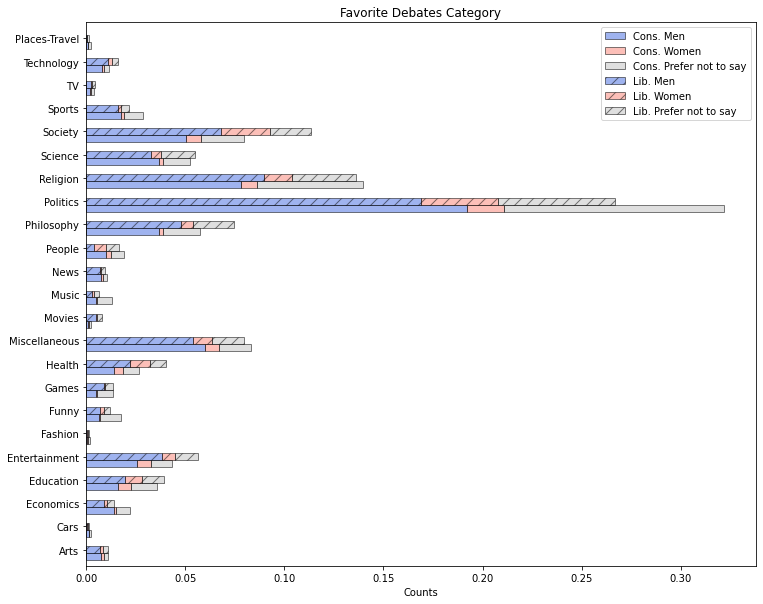

In [18]:
fields=['Arts','Cars', 'Economics', 'Education', 'Entertainment', 'Fashion',
        'Funny', 'Games', 'Health', 'Miscellaneous', 'Movies', 'Music', 'News', 'People',
        'Philosophy', 'Politics', 'Religion','Science', 'Society',
        'Sports', 'TV', 'Technology','Places-Travel',]
counts_men_con=np.array(merging_1[merging_1["gender"]== "Male"]["conservative"])/tot_cons
counts_women_con=np.array(merging_1[merging_1["gender"]== "Female"]["conservative"])/tot_cons
counts_pnts_con=np.array(merging_1[merging_1["gender"]== "Prefer not to say"]["conservative"])/tot_cons
counts_men_lib=np.array(merging_1[merging_1["gender"]== "Male"]["liberal"])/tot_lib
counts_women_lib=np.array(merging_1[merging_1["gender"]== "Female"]["liberal"])/tot_lib
counts_pnts_lib=np.array(merging_1[merging_1["gender"]== "Prefer not to say"]["liberal"])/tot_lib




width = 0.3      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize = (12, 10))
    
ind = np.arange(len(fields))  
plt.barh(ind, counts_men_con, width, label='Cons. Men', color='royalblue',edgecolor="black", alpha=0.5)
plt.barh(ind, counts_women_con, width, left=counts_men_con, label='Cons. Women',color='salmon',edgecolor="black", alpha=0.5)
plt.barh(ind, counts_pnts_con, width, left=counts_men_con+counts_women_con, label='Cons. Prefer not to say',color= 'silver',edgecolor="black", alpha=0.5)
plt.barh(ind+width, counts_men_lib, width, label='Lib. Men', color='royalblue', edgecolor="black", hatch="//", alpha=0.5)
plt.barh(ind+width, counts_women_lib, width, left=counts_men_lib, label='Lib. Women',color='salmon', edgecolor="black", hatch="//",alpha=0.5)
plt.barh(ind+width, counts_pnts_lib, width, left=counts_men_lib+counts_women_lib, label='Lib. Prefer not to say',color= 'silver',edgecolor="black",hatch="//", alpha=0.5)



ax.set(yticks=ind + width, yticklabels=fields, ylim=[2*width - 1, len(fields)])
ax.set_xlabel('Counts')
ax.set_title('Favorite Debates Category')
ax.legend()

plt.show()

In [19]:
#Conservatives users' religion 
c.execute('SELECT count(users.url) as counts,users.gender, users.religion FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Conservative" GROUP BY users.gender,users.religion')
c.fetchall()

[(20, 'Female', 'Agnostic'),
 (3, 'Female', 'Atheist'),
 (186, 'Female', 'Christian'),
 (2, 'Female', 'Christian - Amish'),
 (1, 'Female', 'Christian - Assemblies of God'),
 (40, 'Female', 'Christian - Baptist'),
 (47, 'Female', 'Christian - Catholic'),
 (5, 'Female', 'Christian - Church of Christ'),
 (12, 'Female', 'Christian - Episcopalian'),
 (1, 'Female', 'Christian - Greek Orthodox'),
 (4, 'Female', 'Christian - Latter-Day Saints'),
 (20, 'Female', 'Christian - Lutheran'),
 (10, 'Female', 'Christian - Methodist'),
 (7, 'Female', 'Christian - Pentecostal'),
 (1, 'Female', 'Christian - Presbytarian'),
 (70, 'Female', 'Christian - Protestant'),
 (3, 'Female', 'Hindu'),
 (1, 'Female', 'Jewish - Orthodox'),
 (1, 'Female', 'Muslim'),
 (3, 'Female', 'Muslim - Sunni'),
 (1, 'Female', 'Neo-Paganism'),
 (69, 'Female', 'Not Saying'),
 (1, 'Female', 'Other'),
 (7, 'Female', 'Pagan'),
 (1, 'Female', 'Primal-Indigenous'),
 (3, 'Female', 'Scientology'),
 (2, 'Female', 'Spiritism'),
 (16, 'Male',

In [20]:
#Liberal users' religion 
c.execute('SELECT count(users.url) as counts, users.religion FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Liberal" GROUP BY users.religion')
c.fetchall()

[(845, 'Agnostic'),
 (1225, 'Atheist'),
 (2, 'Bah��'),
 (43, 'Buddhist'),
 (1, 'Buddhist - Mahayana'),
 (2, 'Buddhist - Vajrayana'),
 (320, 'Christian'),
 (12, 'Christian - Amish'),
 (28, 'Christian - Anglican'),
 (2, 'Christian - Assemblies of God'),
 (52, 'Christian - Baptist'),
 (311, 'Christian - Catholic'),
 (62, 'Christian - Church of Christ'),
 (1, 'Christian - Episcopalian'),
 (37, 'Christian - Greek Orthodox'),
 (3, "Christian - Jehovah's Witness"),
 (31, 'Christian - Latter-Day Saints'),
 (15, 'Christian - Lutheran'),
 (1, 'Christian - Mennonite'),
 (21, 'Christian - Methodist'),
 (3, 'Christian - Pentecostal'),
 (3, 'Christian - Presbytarian'),
 (41, 'Christian - Protestant'),
 (17, 'Christian - Seventh-Day Adventist'),
 (4, 'Confucian'),
 (6, 'Daoist'),
 (31, 'Deism'),
 (16, 'Hindu'),
 (1, 'Hindu - Vaishnavism'),
 (11, 'Islamic'),
 (1, 'Jain'),
 (45, 'Jewish'),
 (6, 'Jewish - Conservative'),
 (3, 'Jewish - Orthodox'),
 (42, 'Jewish - Reform'),
 (40, 'Muslim'),
 (8, 'Muslim 

In [21]:
#debates title with users and category
debates = pd.read_sql_query('SELECT participant_1_link,category,title, participant_1_position FROM debates ', cnx)
debates

,participant_1_link,category,title,participant_1_position
0,/Mikal/,Miscellaneous,Covenys recent behavior would be a net detrime...,Pro (for)
1,/Mikal/,Politics,Islam is a civilized religion,Con (against)
2,/Mikal/,Games,Gaming is a sport,Pro (for)
3,/JimShady/,Music,"Rap Battle of Amazingness, 13",Con (against)
4,/Mikal/,Miscellaneous,Racial/Religious Profiling Is a Rational Polit...,Pro (for)
...,...,...,...,...
81794,/backwardseden/,Religion,Young Boy Found at a New Mexico Compound Died ...,Con (against)
81795,/Thomasmariel33/,Politics,When governments employ the term strike (as in...,Pro (for)
81796,/Thomasmariel33/,Society,Should the words poor and homeless be eradicat...,Pro (for)
81797,/Thomasmariel33/,Movies,"Does the voice, Calling Jesse's name as she sl...",Pro (for)


In [22]:
debates.columns

Index(['participant_1_link', 'category', 'title', 'participant_1_position'], dtype='object')

In [23]:
#users
users = pd.read_sql_query('SELECT * FROM users', cnx)
users.head()

,url,last_online,last_updated,joined,president,ideology,party,relationship,interested,looking,...,number_of_friends,about,activities,beliefs,books,movies,music,quotes,sports_teams,tv_shows
0,/Mikal/,2 Years Ago,4 Years Ago,8 Years Ago,Other,Conservative,Independent,- Private -,- Private -,- Private -,...,Mikal's friends are private.,None,None,None,None,None,None,None,None,None
1,/bsh1/,3 Weeks Ago,2 Years Ago,8 Years Ago,Not Saying,Liberal,Democratic Party,- Private -,- Private -,- Private -,...,bsh1's friends are private.,None,None,None,None,None,None,None,None,None
2,/RoyLatham/,3 Years Ago,7 Years Ago,13 Years Ago,Other,Conservative,Republican Party,Married,- Private -,- Private -,...,642 Friends,None,"Photography, travel, blogging, and debate. I a...","I am a Conservative, tending to libertarian. I...","I have lots of favorites. Recently, Charles Kr...","Blazing Saddles, Young Frankenstein, Kung Fu H...","Hawaiian: Israel Kamakawewo'ole, Darlene Ahuna...","""I'm not afraid to die,"" I said. ""I'm not afra...","None, no interest.",I watch a lot of C-SPAN2 and the cable news ch...
3,/Danielle/,1 Year Ago,4 Years Ago,13 Years Ago,Not Saying,Not Saying,Not Saying,- Private -,- Private -,- Private -,...,Danielle's friends are private.,None,Fantasy Football. Jet Skiing. Raving Against t...,Atheist. Capitalist. Existentialist. Feminist....,A People's History of the U.S. Being and Nothi...,A Bronx Tale. Almost Famous. American Beauty. ...,Alabama Shakes. Amy Winehouse. Billy Joel. The...,"""Politics and crime, they're the same thing."" ...",All of my NFL Fantasy teams.,Arrested Development. Dexter. House of Cards. ...
4,/bluesteel/,2 Years Ago,5 Years Ago,11 Years Ago,Vern Wuensche (Republican Party),Conservative,Republican Party,Married,in Men and Women,No Answer,...,604 Friends,None,Modeling,There's not much more to life than being reall...,psh,Zoolander,None,"""I'm gonna be inside bluesteel."" - Oryus",None,None


In [24]:
#users
users.columns

Index(['url', 'last_online', 'last_updated', 'joined', 'president', 'ideology',
       'party', 'relationship', 'interested', 'looking', 'real_name', 'gender',
       'birthday', 'email', 'education', 'ethnicity', 'income', 'occupation',
       'religion', 'number_of_all_debates', 'number_of_lost_debates',
       'number_of_tied_debates', 'number_of_won_debates', 'win_ratio',
       'percentile', 'elo_ranking', 'number_of_forum_posts',
       'number_of_votes_cast', 'number_of_opinion_arguments',
       'number_of_opinion_questions', 'number_of_poll_votes',
       'number_of_poll_topics', 'number_of_friends', 'about', 'activities',
       'beliefs', 'books', 'movies', 'music', 'quotes', 'sports_teams',
       'tv_shows'],
      dtype='object')

In [25]:
#selecting only the useful columns like party,religion, ethnicity etc
users=users[['url','ideology','party','gender','ethnicity','religion','win_ratio']]
users

,url,ideology,party,gender,ethnicity,religion,win_ratio
0,/Mikal/,Conservative,Independent,Male,White,Agnostic,96.84%
1,/bsh1/,Liberal,Democratic Party,Male,Not Saying,Agnostic,95.60%
2,/RoyLatham/,Conservative,Republican Party,Male,Not Saying,Atheist,93.28%
3,/Danielle/,Not Saying,Not Saying,Female,Not Saying,Other,92.12%
4,/bluesteel/,Conservative,Republican Party,Female,White,Christian,98.11%
...,...,...,...,...,...,...,...
38812,/ddo.votebombcounter3/,Not Saying,Not Saying,Prefer not to say,Not Saying,Not Saying,0.00%
38813,/ddo.votebombcounter2/,Not Saying,Not Saying,Prefer not to say,Not Saying,Not Saying,0.00%
38814,/nate54321/,Not Saying,Not Saying,Male,Not Saying,Not Saying,0.00%
38815,/nvreynolds/,Not Saying,Not Saying,Male,Not Saying,Not Saying,0.00%


In [26]:
interval = re.compile('^(\d+\.\d+)\%$')

def read(elem):
    m=interval.search(elem)
    if m:
        num = float(m.group(1))
        return((num)/100)
users['win_ratio']=users['win_ratio'].apply(read)

In [27]:
deb_users=pd.merge(debates, users, how='left', left_on='participant_1_link', right_on='url')

In [28]:
deb_users=deb_users[['category','title','url','ideology','party','gender','ethnicity','religion','participant_1_position','win_ratio']]
deb_users=deb_users.rename(columns=({'url':'username', 'participant_1_position':'user_position'}))

In [29]:
deb_users

,category,title,username,ideology,party,gender,ethnicity,religion,user_position,win_ratio
0,Miscellaneous,Covenys recent behavior would be a net detrime...,/Mikal/,Conservative,Independent,Male,White,Agnostic,Pro (for),0.9684
1,Politics,Islam is a civilized religion,/Mikal/,Conservative,Independent,Male,White,Agnostic,Con (against),0.9684
2,Games,Gaming is a sport,/Mikal/,Conservative,Independent,Male,White,Agnostic,Pro (for),0.9684
3,Music,"Rap Battle of Amazingness, 13",/JimShady/,Conservative,Republican Party,Prefer not to say,Not Saying,Christian - Catholic,Con (against),0.7241
4,Miscellaneous,Racial/Religious Profiling Is a Rational Polit...,/Mikal/,Conservative,Independent,Male,White,Agnostic,Pro (for),0.9684
...,...,...,...,...,...,...,...,...,...,...
81794,Religion,Young Boy Found at a New Mexico Compound Died ...,/backwardseden/,Socialist,Democratic Socialists Party,Prefer not to say,White,Atheist,Con (against),0.0286
81795,Politics,When governments employ the term strike (as in...,/Thomasmariel33/,Not Saying,Not Saying,Prefer not to say,Not Saying,Not Saying,Pro (for),0.0000
81796,Society,Should the words poor and homeless be eradicat...,/Thomasmariel33/,Not Saying,Not Saying,Prefer not to say,Not Saying,Not Saying,Pro (for),0.0000
81797,Movies,"Does the voice, Calling Jesse's name as she sl...",/Thomasmariel33/,Not Saying,Not Saying,Prefer not to say,Not Saying,Not Saying,Pro (for),0.0000


In [30]:
deb_users_cat=deb_users.copy()

In [31]:
deb_users_cat=deb_users[['ideology','category','party','ethnicity','religion','gender']].apply(lambda x: pd.factorize(x)[0])

In [32]:
deb_users_cat.corr(method='pearson', min_periods=1)

,ideology,category,party,ethnicity,religion,gender
ideology,1.000000,-0.058536,0.447406,0.219097,0.211110,0.179568
category,-0.058536,1.000000,-0.037972,0.019219,-0.019741,0.051878
party,0.447406,-0.037972,1.000000,0.188706,0.225443,0.165034
ethnicity,0.219097,0.019219,0.188706,1.000000,0.242617,0.308312
religion,0.211110,-0.019741,0.225443,0.242617,1.000000,0.157741
gender,0.179568,0.051878,0.165034,0.308312,0.157741,1.000000


In [33]:
#the correlation among party and ideology is higher the 0.4, that's why in order to have a smoother svm classification, I decided to keep just the ideology


### Building a Support Vector Machine Model

The goal is to build a support vector machine model to predict to which groups people belong to, based on the title's debate.
The variables to predict are:

    1) Gender: Male, Female, Prefer not say, LGBTQIAPK+;
    2) Ideology: Leftist, centric, Rightist, Apathetic/Undecided, Prefer not to say;
    3) Ethnicity: Asian,Black,East Indian,Latino,Middle Eastern,Native American,Not Saying,Other,Pacific Islander,White;    

In [34]:
username = re.compile('^.(\w+).$')

def find_username(elem):
    m=username.search(str(elem))
    if m:
        un = m.group(1)
        return un
    
deb_users['username']=deb_users['username'].apply(find_username)

In [35]:
deb_users.groupby("party")[ "username"].count()

party
 Christian Falangist Party                19
America First Party                       62
America's Party                            5
American Independent Party                80
American Nazi Party                      238
American Party                            32
American Reform Party                     10
American Third Position Party              3
Boston Tea Party                          72
Christian Liberty Party                   18
Citizens Party of the United States       39
Communist Party                          300
Constitution Party                       221
Democratic Party                        4555
Democratic Socialists Party              854
Freedom Socialist Party                   13
Green Party                              483
Independence Party                       144
Independent                             2614
Independent American Party               172
Jefferson Republican Party                19
Justice Party                             28
Labo

In [36]:
deb_users.groupby("ideology")[ "username"].count()

ideology
Anarchist        1268
Apathetic         430
Communist         783
Conservative     6514
Green             513
Labor             125
Liberal          4154
Libertarian      3638
Moderate         2633
Not Saying      37660
Other            2464
Progressive      2182
Socialist        2349
Undecided        2464
Name: username, dtype: int64

In [37]:
#We can divide the ideology into three main groups: left, right and center.   

In [38]:
deb_users.groupby("ethnicity")[ "username"].count()

ethnicity
Asian                3048
Black                1717
East Indian           357
Latino               1188
Middle Eastern        361
Native American       450
Not Saying          35908
Other                1979
Pacific Islander      222
White               21947
Name: username, dtype: int64

In [39]:
deb_users.groupby("religion", as_index=False)["username"].count().sort_values(by="username")

,religion,username
67,Yarsani,1
46,Mazdakism,1
64,Tenrikyo,3
45,Manichaeism,3
44,Mandaeism,3
...,...,...
15,Christian - Catholic,2969
1,Agnostic,4237
10,Christian,6366
2,Atheist,9217


In [40]:
deb_users.groupby("gender")[ "username"].count()

gender
Agender                  63
Androgyne                87
Bigender                 20
Female                 7295
Genderqueer             104
Male                  24685
Prefer not to say     34869
Transgender Female       23
Transgender Male         31
Name: username, dtype: int64

In [41]:
def groupping_gender(x):
    #gender
    if x in ("Agender","Androgyne","Bigender","Genderqueer","Transgender Female","Transgender Male"):
        x = "LGBTQIAPK+" 
    return x 
def groupping_ideol(x):    
    #ideology
    if x in ("Apathetic","Undecided","Other","Not Saying"):
        x="Other"
    elif x in ("Anarchist","Communist","Green","Socialist"):
        x="Left"
    elif x in ("Labor","Moderate","Progressive"):
        x="Center"
    else:
        x= "Right"
    return x

def groupping_religion(x):
    if x in ("Agnostic","Atheist"):
        x=x
    elif x in ("Christian - Catholic", "Christian","Christian - Mennonite", "Christian - Amish","Christian - Episcopalian","Christian - Jehovah's Witness","Christian - Seventh-Day Adventist","Christian - Assemblies of God","Christian - Anglican","Christian - Greek Orthodox","Christian - Presbytarian","Christian - Pentecosta","Christian - Methodist","Christian - Church of Christ","Christian - Lutheran","Christian - Latter-Day Saints","Christian - Protestant","Christian - Baptist"):
        x="Christian"
    elif x in ("Muslim - Sufi","Muslim - Shiite","Islamic","Muslim - Sunni","Muslim"):
        x="Muslim"
    else:
        x="Other"
    return x

position = re.compile('^([A-Z][a-z]+)\s.(\w+).$')

def pos(elem):
    m=position.search(str(elem))
    if m:
        un = m.group(2)
        return un


In [42]:
deb_users["user_position"]=deb_users["user_position"].apply(pos)
deb_users["religion"]=deb_users["religion"].apply(groupping_religion)
deb_users["gender"]=deb_users["gender"].apply(groupping_gender)
deb_users["ideology"]=deb_users["ideology"].apply(groupping_ideol)

In [43]:
deb_users.head()

,category,title,username,ideology,party,gender,ethnicity,religion,user_position,win_ratio
0,Miscellaneous,Covenys recent behavior would be a net detrime...,Mikal,Right,Independent,Male,White,Agnostic,for,0.9684
1,Politics,Islam is a civilized religion,Mikal,Right,Independent,Male,White,Agnostic,against,0.9684
2,Games,Gaming is a sport,Mikal,Right,Independent,Male,White,Agnostic,for,0.9684
3,Music,"Rap Battle of Amazingness, 13",JimShady,Right,Republican Party,Prefer not to say,Not Saying,Christian,against,0.7241
4,Miscellaneous,Racial/Religious Profiling Is a Rational Polit...,Mikal,Right,Independent,Male,White,Agnostic,for,0.9684


#### Variables distribution

Text(0.5, 1.0, 'Religions')

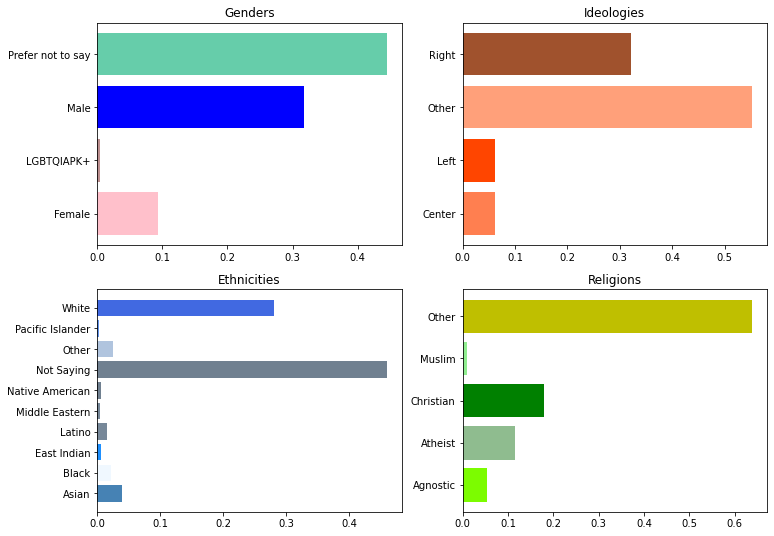

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

#gender
gender=['Female','LGBTQIAPK+','Male','Prefer not to say']
gender_counts=np.array(deb_users.groupby("gender")["title"].count())/len(deb_users)
ax[0,0].barh(gender,gender_counts,color=['pink','rosybrown','blue','mediumaquamarine'])
ax[0,0].set_title("Genders")

#ideology
_id=["Center", "Left","Other","Right"]
id_counts=np.array(deb_users.groupby("ideology")["title"].count())/len(deb_users)
ax[0,1].barh(_id,id_counts,color=['coral','orangered','lightsalmon','sienna'])
ax[0,1].set_title("Ideologies")

#ethinicity
etn=['Asian','Black','East Indian','Latino','Middle Eastern','Native American','Not Saying','Other','Pacific Islander','White']
etn_counts=np.array(deb_users.groupby("ethnicity")["title"].count())/len(deb_users)
ax[1,0].barh(etn,etn_counts,color=['steelblue','aliceblue','dodgerblue','lightslategray','lightslategrey','slategray','slategrey','lightsteelblue','cornflowerblue','royalblue'])
ax[1,0].set_title("Ethnicities")

#religion
rel=['Agnostic','Atheist','Christian','Muslim','Other']
rel_counts=np.array(deb_users.groupby("religion")["title"].count())/len(deb_users)
ax[1,1].barh(rel,rel_counts,color=['lawngreen','darkseagreen','green','lightgreen','y'])
ax[1,1].set_title("Religions")

Tokenization: breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens. The list of tokens becomes input for further processing.NLTK Library has word_tokenize and sent_tokenize to easily break a stream of text into a list of words or sentences, respectively.

Word Stemming/Lemmatization: The aim of both processes is the same, reducing the inflectional forms of each word into a common base or root. Lemmatization is closely related to stemming. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.


In [45]:
deb_users=pd.read_csv("tokenized.csv")
deb_users

,Unnamed: 0,category,title,username,ideology,party,gender,ethnicity,religion,user_position,win_ratio,title_final
0,0,Miscellaneous,"['covenys', 'recent', 'behavior', 'would', 'be...",Mikal,Right,Independent,Male,White,Agnostic,for,0.9684,"['covenys', 'recent', 'behavior', 'would', 'ne..."
1,1,Politics,"['islam', 'is', 'a', 'civilized', 'religion']",Mikal,Right,Independent,Male,White,Agnostic,against,0.9684,"['islam', 'civilized', 'religion']"
2,2,Games,"['gaming', 'is', 'a', 'sport']",Mikal,Right,Independent,Male,White,Agnostic,for,0.9684,"['gaming', 'sport']"
3,3,Music,"['rap', 'battle', 'of', 'amazingness', ',', '13']",JimShady,Right,Republican Party,Prefer not to say,Not Saying,Christian,against,0.7241,"['rap', 'battle', 'amazingness']"
4,4,Miscellaneous,"['racial/religious', 'profiling', 'is', 'a', '...",Mikal,Right,Independent,Male,White,Agnostic,for,0.9684,"['profiling', 'rational', 'political', 'stance']"
...,...,...,...,...,...,...,...,...,...,...,...,...
81794,81794,Religion,"['young', 'boy', 'found', 'at', 'a', 'new', 'm...",backwardseden,Left,Democratic Socialists Party,Prefer not to say,White,Atheist,against,0.0286,"['young', 'boy', 'find', 'new', 'mexico', 'com..."
81795,81795,Politics,"['when', 'governments', 'employ', 'the', 'term...",Thomasmariel33,Other,Not Saying,Prefer not to say,Not Saying,Other,for,0.0000,"['government', 'employ', 'term', 'strike', 'la..."
81796,81796,Society,"['should', 'the', 'words', 'poor', 'and', 'hom...",Thomasmariel33,Other,Not Saying,Prefer not to say,Not Saying,Other,for,0.0000,"['word', 'poor', 'homeless', 'eradicate', 'pub..."
81797,81797,Movies,"['does', 'the', 'voice', ',', 'calling', 'jess...",Thomasmariel33,Other,Not Saying,Prefer not to say,Not Saying,Other,for,0.0000,"['voice', 'call', 'jesse', 'name', 'sleep', 'c..."


In [75]:
#Pre processing text
# Step - a : Remove blank rows if any.
deb_users['title'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
deb_users['title'] = [entry.lower() for entry in deb_users['title']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
deb_users['title']= [word_tokenize(entry) for entry in deb_users['title']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(deb_users['title']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'title_final'
    deb_users.loc[index,'title_final'] = str(Final_words)

In [81]:
deb_users.to_csv('tokenized.csv')

In [49]:
deb_users=deb_users.rename(columns={'Unnamed: 0':'debate_id'})


The Corpus will be split into two data sets, Training and Test. The training data set will be used to fit the model and the predictions will be performed on the test data set.This can be done through the train_test_split from the sklearn library. The Training Data will have 70% of the corpus and Test data will have the remaining 30% as we have set the parameter test_size=0.3 .

In [48]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(deb_users[["title_final","user_position"]],deb_users['ideology'],test_size=0.3)

Label encode the target variable — This is done to transform Categorical data of string type in the data set into numerical values which the model can understand.

In [49]:
Encoder = LabelEncoder()
Train_Y_1 = Encoder.fit_transform(Train_Y)
Test_Y_1 = Encoder.fit_transform(Test_Y)


Word Vectorization: a general process of turning a collection of text documents into numerical feature vectors. To convert text I used TF-IDF (hacronym than stands for “Term Frequency — Inverse Document” Frequency i.e. components of the resulting scores assigned to each word).
The Term Frequency summarizes how often a given word appears within a document.
The Inverse Document Frequency down scales words that appear a lot across documents.
Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.
The following syntax can be used to first fit the TG-IDF model on the whole corpus. This will help TF-IDF build a vocabulary of words which it has learned from the corpus data and it will assign a unique integer number to each of these words. Their will be maximum of 5000 unique words/features as we have set parameter max_features=5000.
Finally we will transform Train_X and Test_X to vectorized Train_X_Tfidf and Test_X_Tfidf. These will now contain for each row a list of unique integer number and its associated importance as calculated by TF-IDF.


In [50]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(deb_users["title_final"])
Train_X_Tfidf_title = Tfidf_vect.transform(Train_X["title_final"])
Test_X_Tfidf_title = Tfidf_vect.transform(Test_X["title_final"])



In [51]:
Train_X_1_pos = Encoder.fit_transform(Train_X['user_position'])
Test_X_1_pos = Encoder.fit_transform(Test_X['user_position'])


In [52]:
X_train_tfidf = hstack([Train_X_Tfidf_title, Train_X_1_pos.reshape(-1, 1)])
X_test_tfidf = hstack([Test_X_Tfidf_title, Test_X_1_pos.reshape(-1, 1)])

In [53]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_tfidf,Train_Y_1)

SVC(gamma='auto', kernel='linear')

In [54]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test_tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y_1)*100)

SVM Accuracy Score ->  56.89894050529747


In [55]:
print(metrics.classification_report(Test_Y_1, predictions_SVM,target_names=[ "Center","Left","Other","Right"]))

              precision    recall  f1-score   support

      Center       0.52      0.03      0.05      1522
        Left       0.46      0.02      0.04      1511
       Other       0.59      0.90      0.71     13663
       Right       0.47      0.21      0.29      7844

    accuracy                           0.57     24540
   macro avg       0.51      0.29      0.27     24540
weighted avg       0.54      0.57      0.49     24540

